# CycleGAN batch inference
> Provides batch inference functionality for the CycleGAN model.

In [ ]:
#default_exp inference.cyclegan

In [ ]:
#export 
from upit.models.cyclegan import *
from upit.train.cyclegan import *
from upit.data.unpaired import *
from fastai.vision.all import *
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import glob
from fastprogress.fastprogress import progress_bar
import os
import PIL

In [ ]:
#hide
from nbdev.showdoc import *

## Batch inference functionality

If we are given a test set as a folder, we can use the `get_preds_cyclegan` function defined below to perform batch inference on the images in the folder and save the predictions.

I found it easier to write my own inference functionality for the custom CycleGAN model than fastai's built-in functionality. 

I define a PyTorch Dataset that can be used for inference just by passing in the folder with the image files for inference:

In [ ]:
#export
class FolderDataset(Dataset):
    """
    A PyTorch Dataset class that can be created from a folder `path` of images, for the sole purpose of inference. Optional `transforms`
    can be provided.
    
    Attributes: \n
    `self.files`: A list of the filenames in the folder. \n
    `self.totensor`: `torchvision.transforms.ToTensor` transform. \n
    `self.transform`: The transforms passed in as `transforms` to the constructor.
    """
    def __init__(self, path,transforms=None):
        """Constructor for this PyTorch Dataset, need to pass the `path`"""
        self.files = glob.glob(path+'/*')
        self.totensor = torchvision.transforms.ToTensor()
        if transforms:
            self.transform = torchvision.transforms.Compose(transforms)
        else:
            self.transform = lambda x: x
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.files[idx % len(self.files)])
        image = self.totensor(image)
        image = self.transform(image)
        return self.files[idx], image

In [ ]:
show_doc(FolderDataset,title_level=3)

<h3 id="FolderDataset" class="doc_header"><code>class</code> <code>FolderDataset</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>FolderDataset</code>(**\*`args`**, **\*\*`kwds`**) :: `Dataset`

A PyTorch Dataset class that can be created from a folder `path` of images, for the sole purpose of inference. Optional `transforms`
can be provided.

Attributes: 

`self.files`: A list of the filenames in the folder. 

`self.totensor`: `torchvision.transforms.ToTensor` transform. 

`self.transform`: The transforms passed in as `transforms` to the constructor.

Let's create a helper function for making the DataLoader:

In [ ]:
#export
def load_dataset(test_path,bs=4,num_workers=4):
    "A helper function for getting a DataLoader for images in the folder `test_path`, with batch size `bs`, and number of workers `num_workers`"
    dataset = FolderDataset(
            path=test_path,
            transforms=[torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        ) 
    loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=bs,
            num_workers=num_workers,
            shuffle=True
        )
    return loader

In [ ]:
show_doc(load_dataset,title_level=3)

<h3 id="load_dataset" class="doc_header"><code>load_dataset</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>load_dataset</code>(**`test_path`**, **`bs`**=*`4`*, **`num_workers`**=*`4`*)

A helper function for getting a DataLoader for images in the folder `test_path`, with batch size `bs`, and number of workers `num_workers`

In [ ]:
#export
def get_preds_cyclegan(learn,test_path,pred_path,convert_to='B',bs=4,num_workers=4,suffix='tif'):
    """
    A prediction function that takes the Learner object `learn` with the trained model, the `test_path` folder with the images to perform 
    batch inference on, and the output folder `pred_path` where the predictions will be saved, with a batch size `bs`, `num_workers`, 
    and suffix of the prediction images `suffix` (default='png'). 
    """
    
    assert os.path.exists(test_path)
    
    if not os.path.exists(pred_path):
        os.mkdir(pred_path)
    
    test_dl = load_dataset(test_path,bs,num_workers)
    if convert_to=='B': model = learn.model.G_B.cuda()
    else:               model = learn.model.G_A.cuda()
    for i, xb in progress_bar(enumerate(test_dl),total=len(test_dl)):
        fn, im = xb
        preds = (model(im.cuda())/2 + 0.5)
        for i in range(len(fn)):
            new_fn = os.path.join(pred_path,'.'.join([os.path.basename(fn[i]).split('.')[0]+f'_fake{convert_to}',suffix]))                  
            torchvision.utils.save_image(preds[i],new_fn)

In [ ]:
show_doc(get_preds_cyclegan,title_level=3)

<h3 id="get_preds_cyclegan" class="doc_header"><code>get_preds_cyclegan</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>get_preds_cyclegan</code>(**`learn`**, **`test_path`**, **`pred_path`**, **`convert_to`**=*`'B'`*, **`bs`**=*`4`*, **`num_workers`**=*`4`*, **`suffix`**=*`'tif'`*)

A prediction function that takes the Learner object `learn` with the trained model, the `test_path` folder with the images to perform 
batch inference on, and the output folder `pred_path` where the predictions will be saved, with a batch size `bs`, `num_workers`, 
and suffix of the prediction images `suffix` (default='png'). 

In [ ]:
horse2zebra = untar_data('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip')

In [ ]:
folders = horse2zebra.ls().sorted()

In [ ]:
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]

In [ ]:
#cuda
dls = get_dls(trainA_path, trainB_path,load_size=286)
cycle_gan = CycleGAN(3,3,64)
learn = cycle_learner(dls, cycle_gan)
learn.model_dir = '.'
learn = learn.load('../examples/models/h2z-85epoch')

/home/tmabraham/fastai/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [ ]:
#cuda
preds_path = './h2z-preds'
get_preds_cyclegan(learn,str(testA_path),preds_path)

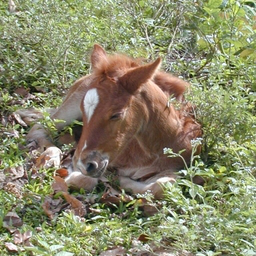

In [ ]:
#cuda
Image.open(testA_path.ls()[100])

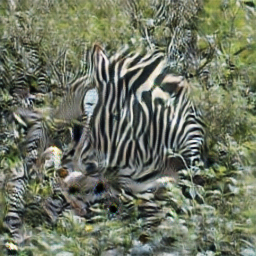

In [ ]:
#cuda
Image.open(os.path.join(preds_path,testA_path.ls()[100].parts[-1][:-4]+'_fakeB.tif'))

In [ ]:
#cuda
preds_path = './z2h-preds'
get_preds_cyclegan(learn,str(testB_path),preds_path,convert_to='A')

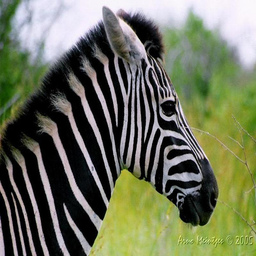

In [ ]:
#cuda
Image.open(testB_path.ls()[100])

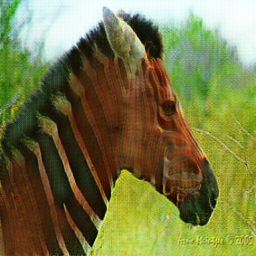

In [ ]:
#cuda
Image.open(os.path.join(preds_path,testB_path.ls()[100].parts[-1][:-4]+'_fakeA.tif'))

# Exporting the Generator

The trained generator can be exported as a PyTorch model file (`.pth`) with the following function:

In [ ]:
#export
def export_generator(learn, generator_name='generator',path=Path('.'),convert_to='B'):
    if convert_to=='B':
        model = learn.model.G_B
    elif convert_to=='A':
        model = learn.model.G_A
    else:
        raise ValueError("convert_to must be 'A' or 'B' (generator that converts either from A to B or B to A)")
    torch.save(model.state_dict(),path/(generator_name+'.pth'))

In [ ]:
#cuda
if os.path.exists('generator.pth'): os.remove('generator.pth')
export_generator(learn)
assert os.path.exists('generator.pth')

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_models.cyclegan.ipynb.
Converted 01b_models.junyanz.ipynb.
Converted 02_data.unpaired.ipynb.
Converted 03_train.cyclegan.ipynb.
Converted 04_inference.cyclegan.ipynb.
Converted index.ipynb.
